# Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design of was heavily inspired by [Torch](http://torch.ch) which is the most convenient neural network environment when the work involves defining new layers. 

This homework requires sending **"multiple** files, please do not forget to include all the files when submit. The list of files:
- This notebook
- assignment1_modules.ipynb
- assignment0_differentiation.ipynb

In [1]:
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import matplotlib

%matplotlib inline

matplotlib.style.use('ggplot')

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return AND store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

In [27]:
"""
    --------------------------------------
    -- Tech note
    --------------------------------------
    Inspired by torch I would use
    
    np.multiply, np.add, np.divide, np.subtract instead of *,+,/,-
    for better memory handling
        
    Suppose you allocated a variable    
        
        a = np.zeros(...)
    
    So, instead of
    
        a = b + c  # will be reallocated, GC needed to free
    
    I would go for: 
    
        np.add(b,c,out = a) # puts result in `a`
    
    But it is completely up to you.
"""
%run assignment1_modules.ipynb

Optimizer is implemented for you. 

In [3]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            cur_old_grad = config['momentum'] * cur_old_grad + config['learning_rate'] * cur_dx
            
            if cur_old_grad.shape[0] == 1:
                cur_x = cur_x.reshape(cur_old_grad.shape)
            
            np.add(cur_x, -cur_old_grad, out=cur_x)
            i += 1     

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

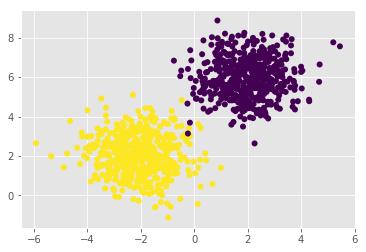

In [4]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([-2,2])
X2 = np.random.randn(N,2) + np.array([2,6])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [5]:
criterion = MSECriterion()

# Test something like that then 

net = Sequential()
net.add(Linear(2, 10))
net.add(LeakyReLU())
net.add(Dropout(0.5))
net.add(Linear(10,20))
net.add(SoftPlus())
net.add(Linear(20,2))
net.add(SoftMax())

print(net)

Linear 2 -> 10
LeakyReLU
Dropout
Linear 10 -> 20
SoftPlus
Linear 20 -> 2
SoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [6]:
# Iptimizer params
optimizer_config = {'learning_rate' : 0.01, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 60
batch_size = 120

In [7]:
# batch generator
def get_batches(X, Y, batch_size):
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

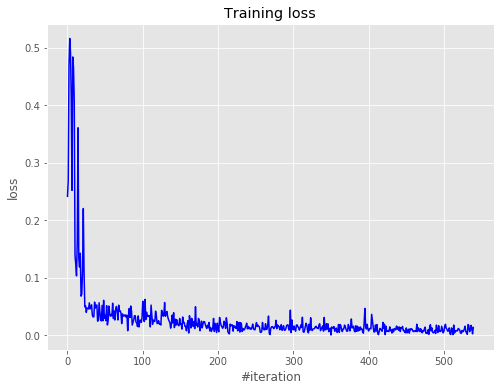

Current loss: 0.013154


In [8]:
loss_history = []
precit =  []
test = []
for i in range(n_epoch):
    for x_batch, y_batch in get_batches(X, Y, batch_size):
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        predict = x_batch
        test = y_batch
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    #  Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)  


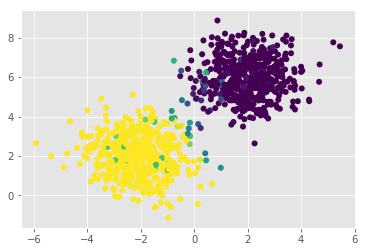

In [9]:
predict, test
plt.scatter(X[:,0],X[:,1], c = net.forward(X)[:,0], edgecolors= 'none')

# Digit classification 

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures. 

In [10]:
from mnist import load_dataset
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()

print(X_train.shape,y_train.shape)
X_train = (X_train.reshape(50000, 28*28))
X_test = (X_test.reshape(10000, 28*28))
# X_train
print(X_train.shape,y_train.shape)

(50000, 1, 28, 28) (50000,)
(50000, 784) (50000,)


One-hot encode the labels first.

In [11]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
y_train= np.array(enc.fit_transform(y_train.reshape(-1, 1)).todense())
y_test = np.array(enc.fit_transform(y_test.reshape(-1, 1)).todense())
y_train.shape

(50000, 10)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchMeanSubtraction` between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchMeanSubtraction` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Hint: logloss for MNIST should be around 0.5. 

In [86]:
def train(X_train, y_train, net, n_epoch, batch_size, criterion, optimizer_state, optimizer_config):
    loss_history = []
    for i in range(n_epoch):
        loss_h = []
        for x_batch, y_batch in get_batches(X_train, y_train, batch_size):
            net.zeroGradParameters()
            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      

            loss_h.append(loss)
        loss_history.append(np.mean(loss_h))

        #  Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))

        plt.title("Training loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(loss_history, 'b')
        plt.show()

        print('Current loss: %f' % loss) 
    return loss_history


In [13]:
def accuracy_prediction(y_train, prediction):
    true = 0
    for index in range(len(prediction)):
        if np.argmax(y_train[index]) == np.argmax(prediction[index]):
            true +=1
    return true * 100/len(prediction)

def test(X_test, y_test, net, batch_size):
    accuracy = []
    for x_batch, y_batch in get_batches(X_test, y_test, batch_size):
        net.evaluate()
        net.zeroGradParameters()
        # Forward
        predictions = net.forward(x_batch)
        accuracy.append(accuracy_prediction(y_batch, predictions))
    return np.mean(accuracy)

Will try the same model with different activation functions

In [100]:
criterion = ClassNLLCriterion()

# Test something like that then 

net = Sequential()
net.add(Linear(784, 100))
net.add(LeakyReLU())
net.add(Linear(100,50))
net.add(LeakyReLU())
net.add(Linear(50,10))
net.add(SoftMax())

print(net)

Linear 784 -> 100
LeakyReLU
Linear 100 -> 50
LeakyReLU
Linear 50 -> 10
SoftMax



In [101]:
# Iptimizer params
optimizer_config = {'learning_rate' : 0.01, 'momentum': 0.9}
optimizer_state = {}

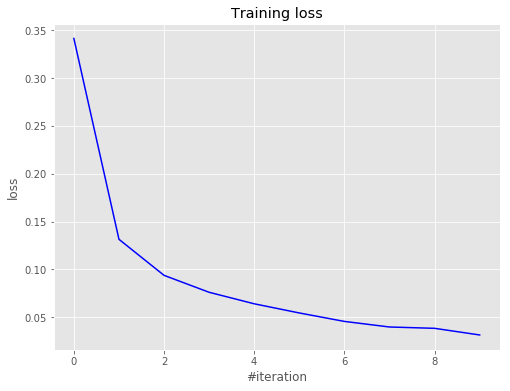

Current loss: 0.017210


In [102]:
loss_nbms = train(X_train, y_train, net, 10, 50, criterion, {}, optimizer_config)

In [103]:
test(X_test, y_test, net, 50)

97.390000000000001

In [19]:
criterion = ClassNLLCriterion()


net = Sequential()
net.add(Linear(784, 100))
net.add(Dropout(0.5))
net.add(ReLU())
net.add(Linear(100,50))
net.add(ReLU())
net.add(Linear(50,10))
net.add(SoftMax())

print(net)

Linear 784 -> 100
Dropout
ReLU
Linear 100 -> 50
ReLU
Linear 50 -> 10
SoftMax



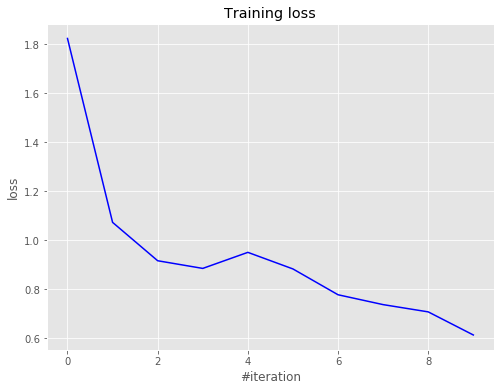

Current loss: 0.736367


In [21]:
train(X_train, y_train, net, 10, 500, criterion, {}, optimizer_config)

In [22]:
test(X_test, y_test, net, 500)

77.610000000000014

In [138]:
criterion = MSECriterion()

# smaller network and learnng rate for ELU, it overflows oterwise
net = Sequential()
net.add(Linear(784, 10))
net.add(ELU())
net.add(SoftMax())

print(net)

Linear 784 -> 10
ELU
SoftMax



In [139]:
optimizer_config = {'learning_rate' : 0.00005, 'momentum': 0.9}

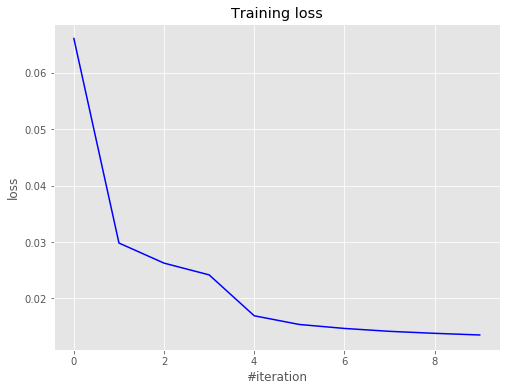

Current loss: 0.014236


[0.066039951752552062,
 0.029817017311438317,
 0.026256880792677528,
 0.024178108419330942,
 0.016933368097729065,
 0.015395462492945303,
 0.014691627648791427,
 0.014179943272213176,
 0.01382772762385402,
 0.013535339939797154]

In [140]:
train(X_train, y_train, net, 10, 50, criterion, {}, optimizer_config)

In [141]:
test(X_train, y_train, net, 500)

91.597999999999999

In [68]:
optimizer_config = {'learning_rate' : 0.005, 'momentum': 0.9}

In [71]:
criterion = ClassNLLCriterion()


net = Sequential()
net.add(Linear(784, 100))
net.add(Dropout(0.5))
net.add(SoftPlus())
net.add(Linear(100,50))
net.add(SoftPlus())
net.add(Linear(50,10))
net.add(SoftMax())

print(net)

Linear 784 -> 100
Dropout
SoftPlus
Linear 100 -> 50
SoftPlus
Linear 50 -> 10
SoftMax



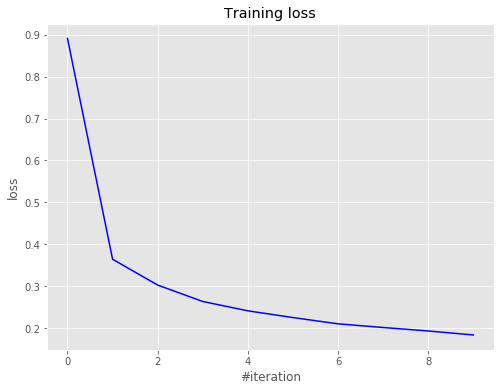

Current loss: 0.051693


In [72]:
train(X_train, y_train, net, 10, 50, criterion, {}, optimizer_config)

In [73]:
test(X_test, y_test, net, 50)

94.010000000000005

I think LeakyELU works better for my case, maybe its faster, because I did small number of epochs
Now will try adding BatchMeanSubtraction between Linear module and activation functions

In [90]:
optimizer_config = {'learning_rate' : 0.01, 'momentum': 0.9}

In [91]:
criterion = ClassNLLCriterion()

# Test something like that then 

net = Sequential()
net.add(Linear(784, 100))
net.add(BatchMeanSubtraction())
net.add(LeakyReLU())
net.add(Linear(100,50))
net.add(BatchMeanSubtraction())
net.add(LeakyReLU())
net.add(Linear(50,10))
net.add(SoftMax())

print(net)

Linear 784 -> 100
BatchMeanNormalization
LeakyReLU
Linear 100 -> 50
BatchMeanNormalization
LeakyReLU
Linear 50 -> 10
SoftMax



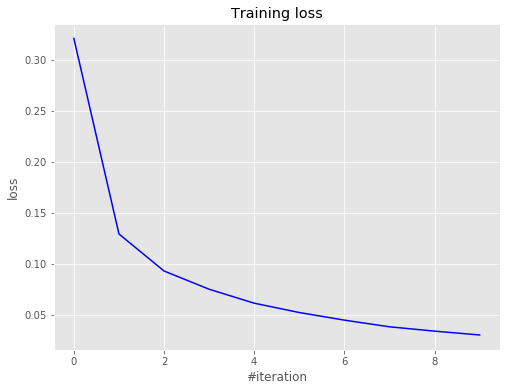

Current loss: 0.012038


In [92]:
loss_bms = train(X_train, y_train, net, 10, 50, criterion, {}, optimizer_config)

In [93]:
test(X_test, y_test, net, 50)

/home/vardges/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:9: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if __name__ == '__main__':


97.569999999999993

Two graphs of leakyRelu with batchmeansubstraction and without

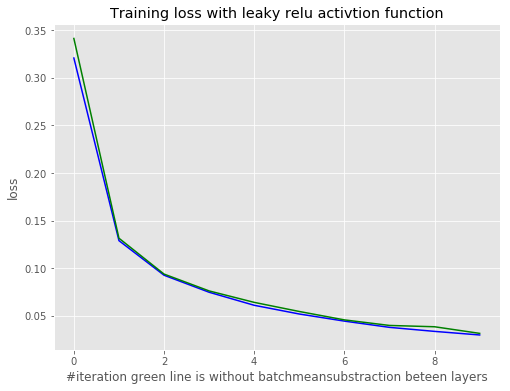

In [109]:
plt.figure(figsize=(8, 6))

plt.title("Training loss with leaky relu activtion function")
plt.xlabel("#iteration green line is without batchmeansubstraction beteen layers")
plt.ylabel("loss")
plt.plot(loss_bms, 'b')
plt.plot(loss_nbms, 'g')
plt.show()

Write your personal opinion on the activation functions, think about computation times too. Does `BatchMeanSubtraction` help?

For me the best worked LeakyRelu, but it can be that way because of my net and custom configs, also batch mean substraction between layers did not help very much as you can see for the graph above

My network that works not very bad

In [111]:
optimizer_config = {'learning_rate' : 0.01, 'momentum': 0.9}

In [112]:
criterion = ClassNLLCriterion()

# Test something like that then 

net = Sequential()
net.add(Dropout(0.8))
net.add(Linear(784, 100))
net.add(LeakyReLU())
net.add(Linear(100,50))
net.add(LeakyReLU())
net.add(Linear(50,10))
net.add(SoftMax())

print(net)

Dropout
Linear 784 -> 100
LeakyReLU
Linear 100 -> 50
LeakyReLU
Linear 50 -> 10
SoftMax



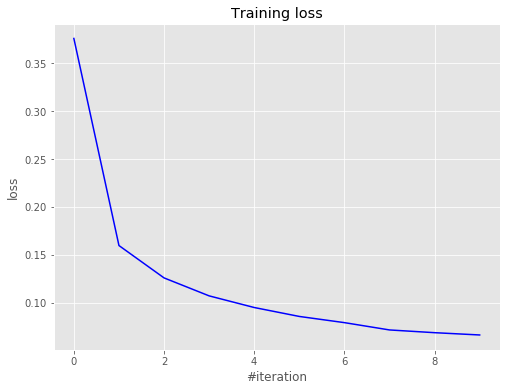

Current loss: 0.027853


[0.37572685681515461,
 0.15973428813508736,
 0.12597249116929837,
 0.10723604917466649,
 0.095090826417049606,
 0.085771821704502857,
 0.07931822121600475,
 0.071690947435711166,
 0.068837097559651339,
 0.066446936502282561]

In [113]:
train(X_train, y_train, net, 10, 50, criterion, {}, optimizer_config)

In [114]:
test(X_test, y_test, net, 50)

97.25

# Autoencoder (optional) 

I will do it later, I promise, but need to do other homeworks first.

This part is **OPTIONAL**, you may not do it. It will not be scored, but it is easy and interesting.

Now we are going to build a cool model, named autoencoder. The aim is simple: **encode** the data to a lower dimentional representation. Why? Well, if we can **decode** this representation back to original data with "small" reconstuction loss then we can store only compressed representation saving memory. But the most important thing is -- we can reuse trained autoencoder for classification. 
![](../imgs/autoencoder.png)

Picture from this [site](http://multithreaded.stitchfix.com/blog/2015/09/17/deep-style/).

Now implement an autoencoder:

Build it such that dimetionality inside autoencoder changes like that: 

$$784 \text{ (data)} -> 512 -> 256 -> 128 -> 30 -> 128 -> 256 -> 512 -> 784$$

Use **MSECriterion** to score the reconstruction. Use **BatchMeanNormalization** between **Linear** and **ReLU**. You may not use nonlinearity in bottleneck layer.

You may train it for 9 epochs with batch size = 256, initial lr = 0.1 droping by a factor of 2 every 3 epochs. The reconstruction loss should be about 6.0 and visual quality decent already.
Do not spend time on changing architecture, they are more or less the same. 

In [ ]:
# Your code goes here. ################################################

Some time ago NNs were a lot poorer and people were struggling to learn deep models. To train a classification net people were training autoencoder first (to train autoencoder people were pretraining single layers with [RBM](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine)), then substituting the decoder part with classification layer (yeah, they were struggling with training autoencoders a lot, and complex techniques were used at that dark times). We are going to this now, fast and easy.  

In [ ]:
# Extract inner representation for train and validation, 
# you should get (n_samples, 30) matrices
# Your code goes here. ################################################

# Now build a logistic regression or small classification net

# Learn the weights
# Your code goes here. ################################################

# Now chop off decoder part
# (you may need to implement `remove` method for Sequential container) 
# Your code goes here. ################################################

# And add learned layers ontop.

# Now optimize whole model
# Your code goes here. ################################################

* What do you think, does it make sense to build real-world classifiers this way ? Did it work better for you than a straightforward one? Looks like it was not the same ~8 years ago, what has changed beside computational power? 

Run PCA with 30 components on the *train set*, plot original image, autoencoder and PCA reconstructions side by side for 10 samples from *validation set*.
Probably you need to use the following snippet to make aoutpencoder examples look comparible.

In [ ]:
# np.clip(prediction,0,1)
#
# Your code goes here. ################################################